


Epoch 1/50

2/2 [==============================] - 5s 1s/step - loss: 0.1943 - val_loss: 0.1172
Epoch 2/50
2/2 [==============================] - 0s 72ms/step - loss: 0.1358 - val_loss: 0.0517
Epoch 3/50
2/2 [==============================] - 0s 70ms/step - loss: 0.0789 - val_loss: 0.0096
Epoch 4/50
2/2 [==============================] - 0s 67ms/step - loss: 0.0560 - val_loss: 0.0025
Epoch 5/50
2/2 [==============================] - 0s 68ms/step - loss: 0.0470 - val_loss: 0.0048
Epoch 6/50
2/2 [==============================] - 0s 122ms/step - loss: 0.0436 - val_loss: 0.0023
Epoch 7/50
2/2 [==============================] - 0s 72ms/step - loss: 0.0341 - val_loss: 0.0022
Epoch 8/50
2/2 [==============================] - 0s 67ms/step - loss: 0.0403 - val_loss: 0.0053
Epoch 9/50
2/2 [==============================] - 0s 73ms/step - loss: 0.0410 - val_loss: 0.0094
Epoch 10/50
2/2 [==============================] - 0s 71ms/step - loss: 0.0399 - val_loss: 0.0130
Epoch 11/50
2/2 [=========

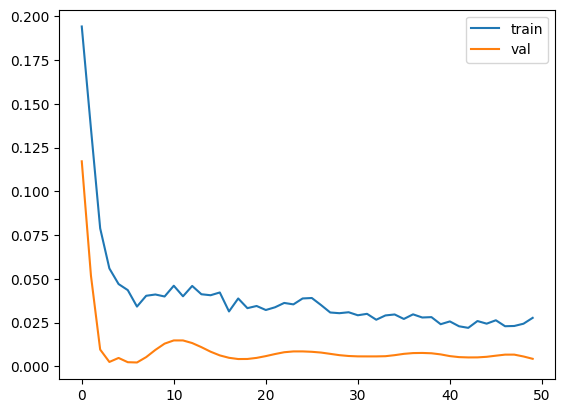

1/1 [==============================] - 0s 32ms/step


,Date,Open,High,Low,Close,Adj Close,Volume,Predicted Sales
113,2024-03-01,61168.062500,73637.476563,59323.910156,73083.500000,73083.500000,6.725220e+11,NaN
114,2024-03-15,71364.554688,72339.546875,66952.093750,68038.859375,68038.859375,7.318893e+10,NaN
115,2024-04-15,NaN,NaN,NaN,NaN,NaN,NaN,42650.671875
116,2024-05-15,NaN,NaN,NaN,NaN,NaN,NaN,43606.820312
117,2024-06-15,NaN,NaN,NaN,NaN,NaN,NaN,43040.300781


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load the dataset
path = r'C:\Users\Jerome Pintucan\OneDrive - TRANSNATIONAL E-BUSINESS SOLUTIONS INC\LEARN\PYTHON\DATASETS\BTC-USD.csv'
df = pd.read_csv(path, parse_dates=['Date'])

# Data preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Create sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Reduce sequence length
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# Split data into training, validation, and testing sets
split_train = int(0.8 * len(X))
split_val = int(0.9 * len(X))
X_train, X_val, X_test = X[:split_train], X[split_train:split_val], X[split_val:]
y_train, y_val, y_test = y[:split_train], y[split_train:split_val], y[split_val:]

# Build LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), shuffle=False)

# Plot training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

# Predict next 3 months data
future_dates = [df['Date'].iloc[-1] + pd.DateOffset(months=i) for i in range(1, 4)]
last_sequence = scaled_data[-sequence_length:]
last_sequence = last_sequence.reshape((1, sequence_length, 1))

predictions = []
for i in range(3):
    prediction = model.predict(last_sequence)
    predictions.append(prediction)
    last_sequence = np.append(last_sequence[:,1:,:], prediction.reshape(1,1,1), axis=1)

predicted_sales = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

predicted_dates = [pd.Timestamp(date) for date in future_dates]

predicted_df = pd.DataFrame({
    'Date': predicted_dates,
    'Predicted Sales': predicted_sales.flatten()
})

df_combined = pd.concat([df, predicted_df], ignore_index=True)

df_combined.tail()
